#### Imports all libraries needed for project

In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter 
from wordcloud import WordCloud
import os
from pathlib import Path


pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_columns", None)

plt.style.use("default")
sns.set_context("notebook")

#### Load `true.csv` and `fake.csv` and print those

In [19]:
# Find project root by walking upward until 'data' exists
ROOT_DIR = Path.cwd()
while not (ROOT_DIR / "data").exists():
    ROOT_DIR = ROOT_DIR.parent

DATA_DIR = ROOT_DIR / "data"

print("ROOT DIR :", ROOT_DIR)
print("DATA DIR :", DATA_DIR)

true_df = pd.read_csv(DATA_DIR / "True.csv")
fake_df = pd.read_csv(DATA_DIR / "Fake.csv")

print("True shape:", true_df.shape)
print("Fake shape:", fake_df.shape)

ROOT DIR : e:\MACHINE LEARNING\NewsDetection\fakeNewsDetection
DATA DIR : e:\MACHINE LEARNING\NewsDetection\fakeNewsDetection\data
True shape: (21417, 4)
Fake shape: (23481, 4)


### Print column names of both datasets.

In [20]:
print("True columns: ", list(true_df.columns))
print("Fake columns: ", list(fake_df.columns))

True columns:  ['title', 'text', 'subject', 'date']
Fake columns:  ['title', 'text', 'subject', 'date']


### Preview Raw Samples

Display a few rows from each dataset.

In [23]:
true_df.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under ...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. ...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator...",politicsNews,"December 31, 2017"


In [22]:
fake_df.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows strong...",News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trum...",News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he ...",News,"December 30, 2017"


### Add Explicit Labels 
* Assigns:
    * `1` : Real News
    * `2` : Fake News

These labels represent source-based truth, not fact-based truth.

We need numeric labels:
* Required for sklearn
* Prevents accidental string-based buds

In [24]:
true_df["label"] = 1
fake_df["label"] = 0

### Combine and Shuffle Dataset.

Concatenates real and fake datasets. Randomly shuffles rows

* Shuffling prevents positional bias
* `random_state` ensure reproducibility

In [26]:
df = pd.concat([true_df, fake_df], axis = 0)

df = df.sample(frac = 1, random_state=42).reset_index(drop=True)

print("Combined dataset shape: ", df.shape)

Combined dataset shape:  (44898, 5)


### Dataset Information Audit:

* Display data types
* Show null values
* Reports memory usage

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


### Class Balance Verification

* Counts fake vs real articles 
* Visualize class distribution 

In [28]:
class_counts = df["label"].value_counts()
class_counts

label
0    23481
1    21417
Name: count, dtype: int64

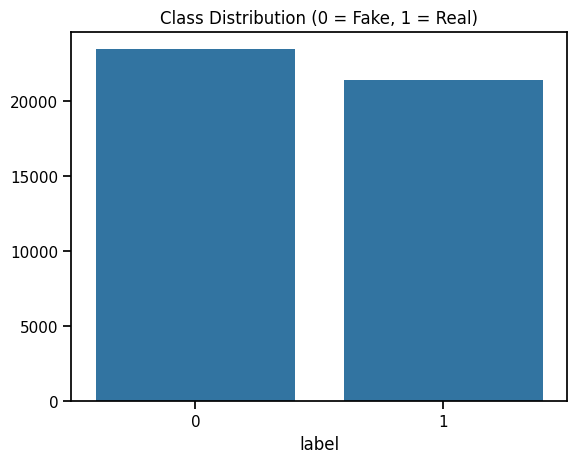

In [29]:
sns.barplot(x=class_counts.index, y = class_counts.values)
plt.title("Class Distribution (0 = Fake, 1 = Real)")
plt.show()

### Missing Value Analysis

In [30]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

### Text and Title Length Analysis 

Computes character length of:
Title. Length is a powerful shortcut feature.

* Fake articles are much shorter 
* Real articles are consistently longer

In [31]:
df["text_length"] = df["text"].astype(str).apply(len)
df["title_length"] = df["title"].astype(str).apply(len)

In [33]:
df.groupby("label")[["text_length", "title_length"]].describe()

text_length                                                         \
            count         mean          std  min     25%     50%     75%   
label                                                                      
0         23481.0  2547.396235  2532.884399  1.0  1433.0  2166.0  3032.0   
1         21417.0  2383.278517  1684.835730  1.0   914.0  2222.0  3237.0   

               title_length                                                 \
           max        count       mean        std   min   25%   50%    75%   
label                                                                        
0      51794.0      23481.0  94.198032  27.184433   8.0  77.0  90.0  105.0   
1      29781.0      21417.0  64.667881   9.168999  26.0  59.0  64.0   70.0   

              
         max  
label         
0      286.0  
1      133.0

### Length Distribution Visualization

Visualizes length distribution on a log scale

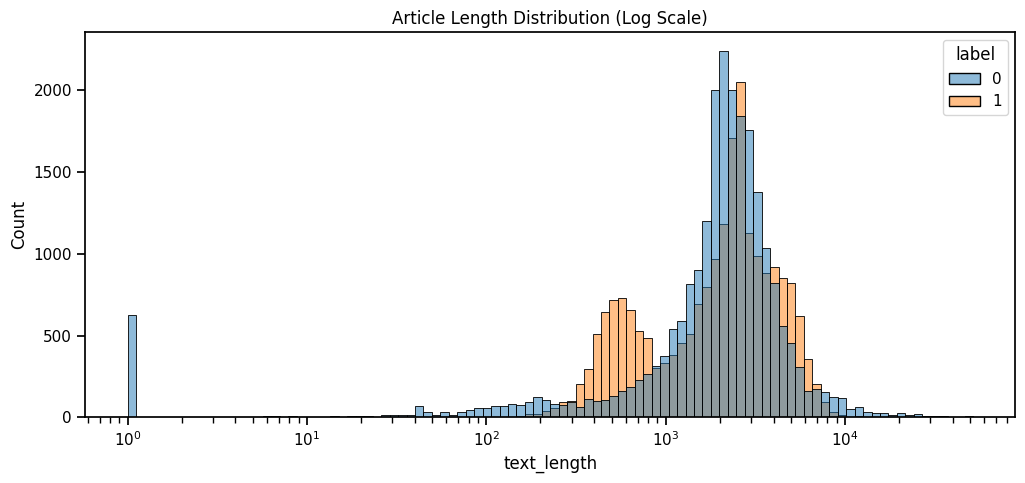

In [34]:
plt.figure(figsize=(12,5))
sns.histplot(
    data = df,
    x = "text_length",
    hue = "label", 
    bins = 100, 
    log_scale=True
)

plt.title("Article Length Distribution (Log Scale)")
plt.show()

### Subject Category Analysis 

Counts articles per subject. Visualizes subject distribution



In [35]:
df["subject"].value_counts().head(15)

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

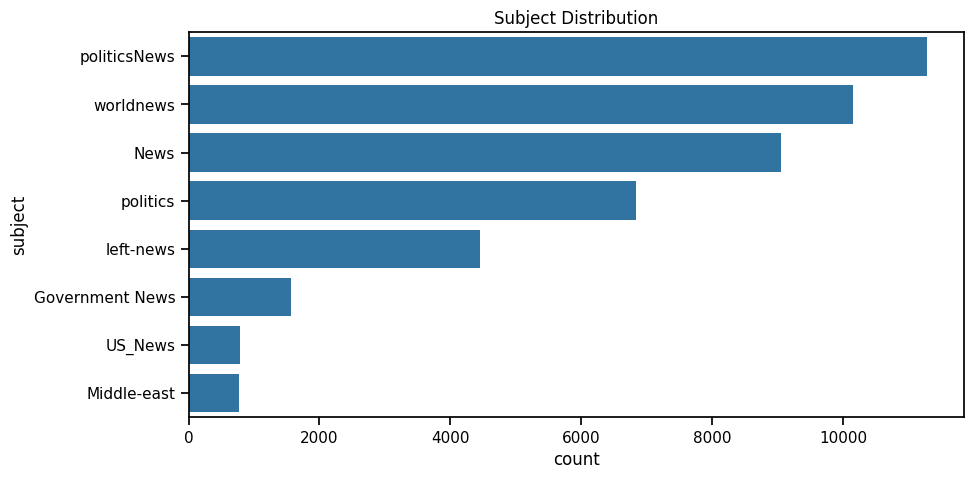

In [37]:
plt.figure(figsize=(10,5))
sns.countplot(
    data = df, 
    y = "subject",
    order = df["subject"].value_counts().index
)

plt.title("Subject Distribution")
plt.show()

### Data Parsing and Temporal Coverage

* Convert string dates to datetime
* Handles malformed dates safely 

In [38]:
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")

In [39]:
df["date_parsed"].describe()

count                            11868
mean     2016-10-07 18:15:24.570272768
min                2015-05-01 00:00:00
25%                2016-04-28 00:00:00
50%                2016-10-04 00:00:00
75%                2017-03-24 00:00:00
max                2017-12-31 00:00:00
Name: date_parsed, dtype: object

In [40]:
df.groupby("label")["date_parsed"].agg(["min", "max"])

,min,max
label,,
0,2015-05-01,2017-12-31
1,NaT,NaT


### Articles Over Time

* Aggregates articles by month
* Plots fake vs real volume over time

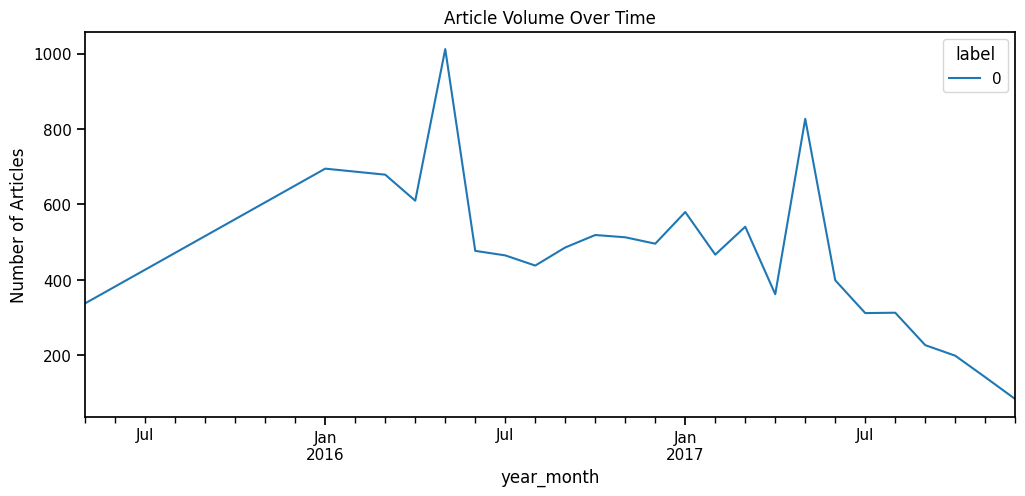

In [41]:
df["year_month"] = df["date_parsed"].dt.to_period("M")

time_counts = df.groupby(["year_month", "label"]).size().unstack(fill_value=0)

time_counts.plot(figsize=(12,5))
plt.title("Article Volume Over Time")
plt.ylabel("Number of Articles")
plt.show()

### Combine Title + Text 
Creates a single content column

* EAD should observe raw signals.
* Removes useful patterns. 

In [43]:
df["content"] = df["title"].astype(str) + " " + df["text"].astype(str)

### Word Frequency Comparison

Finds most common words per class 

This revels:
* Emotional Language
* Political Farming 
* Sensational terms

In [46]:
def get_top_words(texts, n=20):
    words = " ".join(texts).lower().split()
    return Counter(words).most_common(n)

fake_words = get_top_words(df[df["label"]==0]["content"])
real_words = get_top_words(df[df["label"]==1]["content"])

fake_words, real_words

([('the', 531506),
  ('to', 298008),
  ('of', 240302),
  ('and', 225811),
  ('a', 213077),
  ('in', 167339),
  ('that', 145837),
  ('s', 128331),
  ('is', 110477),
  ('for', 95859),
  ('on', 83423),
  ('he', 77929),
  ('trump', 72126),
  ('it', 71238),
  ('was', 67786),
  ('with', 64460),
  ('his', 59513),
  ('as', 56392),
  ('this', 52827),
  ('be', 48709)],
 [('the', 478375),
  ('to', 252167),
  ('of', 207663),
  ('a', 197160),
  ('in', 184092),
  ('and', 181403),
  ('on', 111072),
  ('that', 85058),
  ('for', 81882),
  ('said', 72049),
  ('with', 55570),
  ('is', 55114),
  ('he', 52842),
  ('by', 48070),
  ('as', 47958),
  ('was', 47878),
  ('has', 46277),
  ('s', 44710),
  ('it', 42166),
  ('u.s.', 42148)])

### WordClouds 
Visualizes dominant vocabulary per class

* Humans understand patterns visually faster than tables.

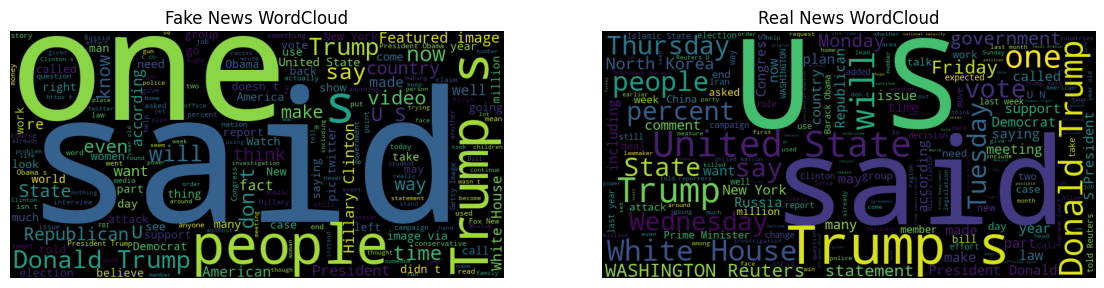

In [47]:
fake_text = " ".join(df[df["label"]==0]["content"])
real_text = " ".join(df[df["label"]==1]["content"])

wc_fake = WordCloud(width=800, height=400, background_color="black").generate(fake_text)
wc_real = WordCloud(width=800, height=400, background_color="black").generate(real_text)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wc_fake)
plt.title("Fake News WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_real)
plt.title("Real News WordCloud")
plt.axis("off")

plt.show()